In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
from imblearn.over_sampling import SMOTE

In [2]:
import models
import class_sampling
import train
import metric_utils
import inference
import loss_fns
import torchvision.ops 

SyntaxError: invalid syntax (class_sampling.py, line 223)

In [ ]:
NUM_CLASSES = 10
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
momentum = 0

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

NUM_CLASSES_REDUCED = 2
nums = (0, 1)
ratio = (10, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
# name, num_classes, classes used, ratio, learning rate, mean 10, variance 10, mean 20, variance 20, ... 50

# mean, variance every 10 epochs - average of 10 models 
# name, num_classes, classes used, ratio, learning rate, mean 10, variance 10, mean 20, variance 20, ... 50
# name: normal/ratio/oversampled/undersampled/weighted

col_names = ["name", 
            "num_classes", 
            "classes_used", 
            "ratio", 
            "learning_rate", 
            "mean_0", "variance_0",
            "mean_10", "variance_10",
            "mean_20", "variance_20",
            "mean_30", "variance_30",
            "mean_40", "variance_40",
            "mean_50", "variance_50",
            "cap"]

rows = []

In [ ]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10, 5000 * NUM_CLASSES_REDUCED)
triplet_train_CIFAR10 = class_sampling.ForTripletLoss(smote_train_CIFAR10)

In [ ]:
targets = ratio_train_CIFAR10.labels 

class_count = np.unique(targets, return_counts=True)[1]
print(class_count)

weight = 1. / class_count

samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= class_count[0]

In [ ]:
beta = 0.999 

exp = np.empty_like(targets)
for i, count in enumerate(class_count):
    exp[targets==i] = count
effective_weights = (1 - beta) / ( 1 - (beta ** torch.from_numpy(exp)))

In [ ]:
print(effective_weights)

In [ ]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

train_loader_tripletloss = DataLoader(triplet_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [10]:
print(test_loader_reduced.dataset.images.shape) # tupe instead of torch.Size() like the others 

torch.Size([2000, 3, 32, 32])


IndexError: list index out of range

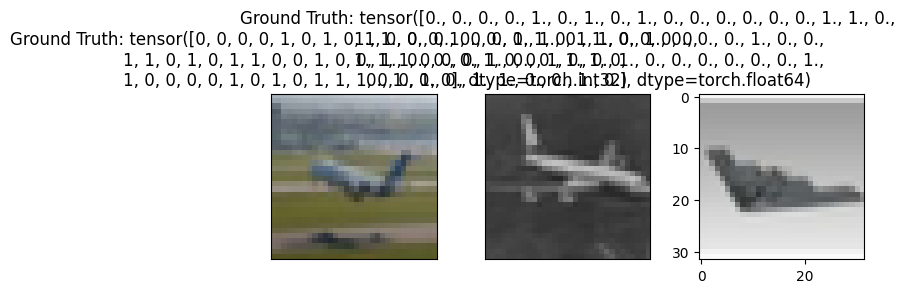

In [11]:
examples = enumerate(train_loader_smote) # enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].reshape(32, 32, 3).int())
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [39]:
# SIGMOID 2 CLASS normal AUC saving  

momentum=0
learning_rates = [2e-5, 3e-5, 5e-5, 7e-5, 9e-5]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)
   


Test set: Avg. loss: 0.024605756759643556, AUC: 0.6469975


Test set: Avg. loss: 0.014931785106658936, AUC: 0.8215375


Test set: Avg. loss: 0.051244140625, AUC: 0.75086


Test set: Avg. loss: 0.12066669464111328, AUC: 0.5902445000000001


Test set: Avg. loss: 0.06057313537597656, AUC: 0.7290795


Test set: Avg. loss: 0.016814103603363037, AUC: 0.8081860000000001


Test set: Avg. loss: 0.020942140579223632, AUC: 0.459742


Test set: Avg. loss: 0.13868421936035155, AUC: 0.504016


Test set: Avg. loss: 0.012890518665313721, AUC: 0.8556889999999999


Test set: Avg. loss: 0.04611336135864258, AUC: 0.6312180000000001


Test set: Avg. loss: 0.020766493797302246, AUC: 0.858468


Test set: Avg. loss: 0.021261009216308593, AUC: 0.8546545000000001


Test set: Avg. loss: 0.04852569198608398, AUC: 0.59049


Test set: Avg. loss: 0.05658713340759278, AUC: 0.7340209999999999


Test set: Avg. loss: 0.013382947444915772, AUC: 0.8688965


Test set: Avg. loss: 0.01964276695251465, AUC: 0.779631



KeyboardInterrupt: 

In [ ]:
print(learning_rate_aucs.shape)
auc_mean = np.mean(learning_rate_aucs, axis=1)
print(auc_mean.shape)
auc_variance = np.var(learning_rate_aucs, axis=1)
print(auc_variance.shape)

for i in range(len(learning_rates)): 
    row = ["normal", 2, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)

print(rows)

# pd.DataFrame(rows, columns = col_names) 

In [ ]:
# SIGMOID 2 CLASS ratio

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS oversampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS undersampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS over+undersampled

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_sampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["both_sampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# SIGMOID 2 CLASS weighted 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = torch.tensor([weight[1]])

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# 2 CLASS Focal Loss 
# no weights (yet)


momentum=0
learning_rates = [1e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6, 5e-7]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['reduction'] = 'mean'


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SigmoidFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [21]:
# 2 class weighted focal loss 

momentum=0
learning_rates = [1e-5, 5e-5, 1e-6, 5e-7]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['reduction'] = 'mean'
loss_fn_args['weight']=torch.tensor([weight[1]])


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SigmoidFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted_focal_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5], None]
    rows.append(row)



Test set: Avg. loss: 0.029068840980529784, AUC: 0.6637670000000001


Test set: Avg. loss: 7.40823779296875, AUC: 0.5


Test set: Avg. loss: 0.5127647399902344, AUC: 0.505503


Test set: Avg. loss: 1.67704736328125, AUC: 0.5


Test set: Avg. loss: 0.11136227798461915, AUC: 0.6836469999999999


Test set: Avg. loss: 3.840927978515625, AUC: 0.5


Test set: Avg. loss: 0.04511044883728027, AUC: 0.4715375000000001


Test set: Avg. loss: 0.6244243774414062, AUC: 0.4995


Test set: Avg. loss: 10.89170458984375, AUC: 0.5


Test set: Avg. loss: 0.1552860107421875, AUC: 0.6288684999999999


Test set: Avg. loss: 0.21777433776855468, AUC: 0.5584169999999999


Test set: Avg. loss: 0.7307884216308593, AUC: 0.5005


Test set: Avg. loss: 0.051012250900268556, AUC: 0.485054


Test set: Avg. loss: 1.6317517700195312, AUC: 0.5


Test set: Avg. loss: 1.6158645629882813, AUC: 0.5


Test set: Avg. loss: 4.6241728515625, AUC: 0.5


Test set: Avg. loss: 0.29889247131347657, AUC: 0.5330250000000001


Test set: 


Test set: Avg. loss: 0.029435909271240235, AUC: 0.774112


Test set: Avg. loss: 0.043125858306884764, AUC: 0.7159804999999999


Test set: Avg. loss: 0.32170054626464845, AUC: 0.4995


Test set: Avg. loss: 0.01369522523880005, AUC: 0.516219


Test set: Avg. loss: 0.12513492584228517, AUC: 0.502995


Test set: Avg. loss: 0.058791873931884765, AUC: 0.6153120000000001


Test set: Avg. loss: 0.13666724395751953, AUC: 0.5024949999999999


Test set: Avg. loss: 0.059439298629760745, AUC: 0.608271


Test set: Avg. loss: 0.021141726493835448, AUC: 0.803672


Test set: Avg. loss: 0.03345775032043457, AUC: 0.45481399999999994


Test set: Avg. loss: 0.02317213726043701, AUC: 0.7973180000000001


Test set: Avg. loss: 0.010115370273590088, AUC: 0.789774


Test set: Avg. loss: 0.5971633605957031, AUC: 0.5


Test set: Avg. loss: 0.06598271942138671, AUC: 0.5879685


Test set: Avg. loss: 0.021370010375976564, AUC: 0.803662


Test set: Avg. loss: 0.02171405029296875, AUC: 0.4277695


Test set: Avg. loss

In [11]:
# 2 Class SMOTE 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]


learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, smote=True)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5], None]
    rows.append(row)




Test set: Avg. loss: 0.02157968044281006, AUC: 0.6867034999999999


Test set: Avg. loss: 0.04202408409118653, AUC: 0.5679595


Test set: Avg. loss: 0.01122785186767578, AUC: 0.7952355


Test set: Avg. loss: 0.009371079921722413, AUC: 0.8330525


Test set: Avg. loss: 0.01840770721435547, AUC: 0.6837489999999999


Test set: Avg. loss: 0.051747398376464845, AUC: 0.6998095


Test set: Avg. loss: 0.023658714294433593, AUC: 0.39837999999999996


Test set: Avg. loss: 0.036989910125732425, AUC: 0.5953179999999999


Test set: Avg. loss: 0.019817763328552247, AUC: 0.8361535000000001


Test set: Avg. loss: 0.06258223724365235, AUC: 0.6625259999999998


Test set: Avg. loss: 0.023065343856811523, AUC: 0.8184055


Test set: Avg. loss: 0.1660221939086914, AUC: 0.5


Test set: Avg. loss: 0.04466410827636719, AUC: 0.5848144999999999


Test set: Avg. loss: 0.019423234939575196, AUC: 0.8312700000000001


Test set: Avg. loss: 0.015033366680145264, AUC: 0.7412275


Test set: Avg. loss: 0.07601138687133789

KeyboardInterrupt: 

In [29]:
# 2 Class SMOTE with capped loss 

momentum=0
learning_rates = [1e-4, 5e-4, 1e-3]


cap_aucs = []

caps = [1, 5, 10]

for cap in caps:
    
    loss_fn_args = {}
    loss_fn_args['loss_cap'] = cap
    
    learning_rate_aucs = []
    
    for learning_rate in learning_rates:
        aucs = []
        for i in range(10):
            model_aucs = []
            network = models.SigmoidLogisticRegression(2, shape=32*32*3)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
            model_aucs.append(auc)
            for epoch in range(n_epochs):
                _, _ = train.train_sigmoid(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args, smote=True)
                if (epoch + 1) % 10 == 0: 
                    _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                    model_aucs.append(auc)
            aucs.append(model_aucs)
        learning_rate_aucs.append(aucs)

    learning_rate_aucs = np.asarray(learning_rate_aucs)

    auc_mean = np.mean(learning_rate_aucs, axis=1)
    auc_variance = np.var(learning_rate_aucs, axis=1)
    
    cap_aucs.append([auc_mean, auc_variance])

for i in range(len(cap_aucs)):
    auc_mean = cap_aucs[i][0]
    auc_variance = cap_aucs[i][1]
    cap = caps[i]
    for i in range(len(learning_rates)): 
        row = ["capped_smote", 2, nums, ratio, learning_rates[i],
                auc_mean[i][0], auc_variance[i][0], 
                auc_mean[i][1], auc_variance[i][1],
                auc_mean[i][2], auc_variance[i][2],
                auc_mean[i][3], auc_variance[i][3],
                auc_mean[i][4], auc_variance[i][4],
                auc_mean[i][5], auc_variance[i][5], cap]
        rows.append(row)



Test set: Avg. loss: 0.024605756759643556, AUC: 0.6469975


Test set: Avg. loss: 0.025179288864135743, AUC: 0.8371780000000001


Test set: Avg. loss: 0.02434657955169678, AUC: 0.835716


Test set: Avg. loss: 0.02363310146331787, AUC: 0.8414855


Test set: Avg. loss: 0.10839350509643554, AUC: 0.659127


Test set: Avg. loss: 0.09762242507934571, AUC: 0.6706274999999999


Test set: Avg. loss: 0.020942140579223632, AUC: 0.459742


Test set: Avg. loss: 0.1355465545654297, AUC: 0.5949840000000001


Test set: Avg. loss: 0.02055882549285889, AUC: 0.8423615


Test set: Avg. loss: 0.09752316284179688, AUC: 0.677659


Test set: Avg. loss: 0.21606256866455079, AUC: 0.534526


Test set: Avg. loss: 0.07548645401000977, AUC: 0.7280519999999999


Test set: Avg. loss: 0.04852569198608398, AUC: 0.59049


Test set: Avg. loss: 0.07702235794067383, AUC: 0.70361


Test set: Avg. loss: 0.056303215026855466, AUC: 0.757323


Test set: Avg. loss: 0.024388296127319336, AUC: 0.8475915


Test set: Avg. loss: 0.13


Test set: Avg. loss: 5.902949951171875, AUC: 0.5


Test set: Avg. loss: 0.317109619140625, AUC: 0.711518


Test set: Avg. loss: 1.88033056640625, AUC: 0.5329925


Test set: Avg. loss: 0.027087728500366212, AUC: 0.4486684999999999


Test set: Avg. loss: 0.20748065948486327, AUC: 0.8004370000000001


Test set: Avg. loss: 5.94118408203125, AUC: 0.5


Test set: Avg. loss: 0.2501363754272461, AUC: 0.7552719999999999


Test set: Avg. loss: 1.7738500366210936, AUC: 0.5050095


Test set: Avg. loss: 1.6469757690429687, AUC: 0.546493


Test set: Avg. loss: 0.02875083065032959, AUC: 0.6469410000000001


Test set: Avg. loss: 2.8680609130859374, AUC: 0.5050044999999999


Test set: Avg. loss: 1.240472900390625, AUC: 0.564488


Test set: Avg. loss: 0.546728515625, AUC: 0.6959295


Test set: Avg. loss: 2.96422998046875, AUC: 0.506


Test set: Avg. loss: 1.3515675048828124, AUC: 0.564991


Test set: Avg. loss: 0.027386792182922365, AUC: 0.402786


Test set: Avg. loss: 0.22187775421142578, AUC: 0.80894


Test set: Avg. loss: 0.1286066246032715, AUC: 0.7922980000000001


Test set: Avg. loss: 0.20144508361816407, AUC: 0.753472


Test set: Avg. loss: 0.3547326507568359, AUC: 0.6704270000000001


Test set: Avg. loss: 0.17192459869384766, AUC: 0.6935100000000001


Test set: Avg. loss: 0.2671983184814453, AUC: 0.7166830000000001


Test set: Avg. loss: 0.03369696426391602, AUC: 0.4749055


Test set: Avg. loss: 0.9279878234863281, AUC: 0.5025000000000001


Test set: Avg. loss: 0.14519380187988282, AUC: 0.7908790000000001


Test set: Avg. loss: 0.23044691467285155, AUC: 0.729785


Test set: Avg. loss: 0.1999288101196289, AUC: 0.7627674999999999


Test set: Avg. loss: 0.970044189453125, AUC: 0.536488


Test set: Avg. loss: 0.012355063438415527, AUC: 0.5283694999999999


Test set: Avg. loss: 0.4322799072265625, AUC: 0.6235390000000001


Test set: Avg. loss: 3.5117054443359375, AUC: 0.5


Test set: Avg. loss: 0.1270251159667969, AUC: 0.8010585


Test set: Avg. loss: 0.27561334228515627, AUC: 0.70


Test set: Avg. loss: 0.17418785095214845, AUC: 0.5809785


Test set: Avg. loss: 0.025650479316711425, AUC: 0.8188964999999999


Test set: Avg. loss: 0.030268095016479493, AUC: 0.8380839999999998


Test set: Avg. loss: 0.04620059967041015, AUC: 0.6466655


Test set: Avg. loss: 0.04102304458618164, AUC: 0.8002800000000001


Test set: Avg. loss: 0.15011007690429687, AUC: 0.602543


Test set: Avg. loss: 0.051661659240722656, AUC: 0.7813510000000001


Test set: Avg. loss: 0.0623509578704834, AUC: 0.768413


Test set: Avg. loss: 0.07724285888671875, AUC: 0.7274444999999999


Test set: Avg. loss: 0.028779868125915528, AUC: 0.4497709999999999


Test set: Avg. loss: 0.12466008377075195, AUC: 0.5160245


Test set: Avg. loss: 0.0765390396118164, AUC: 0.7234185000000001


Test set: Avg. loss: 0.05918923377990723, AUC: 0.7649835


Test set: Avg. loss: 0.30781658935546874, AUC: 0.512494


Test set: Avg. loss: 0.0477901382446289, AUC: 0.6517535000000001


Test set: Avg. loss: 0.0776613655090332, AUC


Test set: Avg. loss: 0.3535929260253906, AUC: 0.6831195000000001


Test set: Avg. loss: 0.31580372619628905, AUC: 0.775344



In [11]:
# 2 class effective # of samples 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = effective_weights

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["effective_samples", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)



Test set: Avg. loss: 0.02157968044281006, AUC: 0.6867034999999999


Test set: Avg. loss: 0.013757909774780273, AUC: 0.7648969999999999


Test set: Avg. loss: 0.013857486248016358, AUC: 0.800988


Test set: Avg. loss: 0.017318458557128907, AUC: 0.8124695


Test set: Avg. loss: 0.009805487632751466, AUC: 0.8018260000000001


Test set: Avg. loss: 0.014841811656951904, AUC: 0.8085429999999999


Test set: Avg. loss: 0.023658714294433593, AUC: 0.39837999999999996


Test set: Avg. loss: 0.026063546180725098, AUC: 0.7488279999999999


Test set: Avg. loss: 0.01888744068145752, AUC: 0.765158


Test set: Avg. loss: 0.019569753646850586, AUC: 0.7862880000000001


Test set: Avg. loss: 0.008232975006103515, AUC: 0.7549595


Test set: Avg. loss: 0.011351889610290527, AUC: 0.7745679999999999


Test set: Avg. loss: 0.04466410827636719, AUC: 0.5848144999999999


Test set: Avg. loss: 0.02735144519805908, AUC: 0.7608940000000001


Test set: Avg. loss: 0.014998260974884034, AUC: 0.775344


Test set: Avg. 

KeyboardInterrupt: 

In [10]:
# 2 class triplet loss w/ SMOTE --> CONVNET, change files 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]


learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_with_triplet_loss(epoch, train_loader_tripletloss, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote_triplet_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], None]
    rows.append(row)


Test set: Avg. loss: 0.0008116806149482727, AUC: 0.6054329999999999

Train Epoch: 0 [0/10000 (0%)]	Loss: 7542.551270
Train Epoch: 0 [640/10000 (6%)]	Loss: 1.000539
Train Epoch: 0 [1280/10000 (13%)]	Loss: 0.998103
Train Epoch: 0 [1920/10000 (19%)]	Loss: 1.001201
Train Epoch: 0 [2560/10000 (25%)]	Loss: 1.004069


KeyboardInterrupt: 

In [ ]:
NUM_CLASSES_REDUCED = 3
nums = (0, 3, 1)
ratio = (200, 20, 1)


reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)
targets = ratio_train_CIFAR10.labels 
class_count = np.unique(targets, return_counts=True)[1]

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10, 5000 * NUM_CLASSES_REDUCED)


weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= max(class_count)


train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [ ]:
# Softmax 3 class normal

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 3, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class ratio

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class oversampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class undersampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class both sampled

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_sampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["both_sampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class weighted

learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['weight'] = torch.from_numpy(class_weights).float()

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# Softmax 3 class focal loss 

learning_rates = [1e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6, 5e-7]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['reduction'] = 'mean'

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SoftmaxFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5]]
    rows.append(row)


In [ ]:
# 3 class SMOTE 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8]



learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(3, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedCELoss, smote=True)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)
    
learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3],
            auc_mean[i][4], auc_variance[i][4],
            auc_mean[i][5], auc_variance[i][5], 'n/a']
    rows.append(row)


In [ ]:
# 3 Class SMOTE with capped loss 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7]


cap_aucs = []

caps = [1, 5, 10]

for cap in caps:
    
    loss_fn_args = {}
    loss_fn_args['loss_cap'] = cap
    
    learning_rate_aucs = []
    
    for learning_rate in learning_rates:
        aucs = []
        for i in range(10):
            model_aucs = []
            network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
            model_aucs.append(auc)
            for epoch in range(n_epochs):
                _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedCELoss, loss_fn_args=loss_fn_args, smote=True)
                if (epoch + 1) % 10 == 0: 
                    _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                    model_aucs.append(auc)
            aucs.append(model_aucs)
        learning_rate_aucs.append(aucs)

    learning_rate_aucs = np.asarray(learning_rate_aucs)

    auc_mean = np.mean(learning_rate_aucs, axis=1)
    auc_variance = np.var(learning_rate_aucs, axis=1)
    
    cap_aucs.append([auc_mean, auc_variance])

for i in range(len(cap_aucs)):
    auc_mean = cap_aucs[i][0]
    auc_variance = cap_aucs[i][1]
    cap = caps[i]
    for i in range(len(learning_rates)): 
        row = ["capped_smote", 3, nums, ratio, learning_rates[i],
                auc_mean[i][0], auc_variance[i][0], 
                auc_mean[i][1], auc_variance[i][1],
                auc_mean[i][2], auc_variance[i][2],
                auc_mean[i][3], auc_variance[i][3],
                auc_mean[i][4], auc_variance[i][4],
                auc_mean[i][5], auc_variance[i][5], cap]
        rows.append(row)


In [30]:
df1 = pd.read_csv('results/auc_analysis_other_methods.csv')

df2 = pd.DataFrame(rows, columns = col_names)

df = pd.concat([df1, df2])

In [31]:

df2.head(20)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50,cap
0,capped_smote,2,"(0, 1)","(10, 1)",0.0001,0.555118,0.008864,0.688820,0.014818,0.714489,0.009811,0.765031,0.003524,0.653442,0.004531,0.712068,0.011892,1
1,capped_smote,2,"(0, 1)","(10, 1)",0.0005,0.513105,0.007350,0.661740,0.011216,0.635448,0.009486,0.680485,0.014542,0.683445,0.012008,0.654911,0.009386,1
2,capped_smote,2,"(0, 1)","(10, 1)",0.0010,0.521312,0.009090,0.639514,0.012413,0.633605,0.011966,0.649443,0.015718,0.652272,0.010946,0.623615,0.007430,1
3,capped_smote,2,"(0, 1)","(10, 1)",0.0001,0.517521,0.007951,0.605812,0.013855,0.615380,0.018370,0.763264,0.009034,0.760086,0.006114,0.729391,0.009485,5
4,capped_smote,2,"(0, 1)","(10, 1)",0.0005,0.531704,0.002876,0.707857,0.013717,0.610216,0.012469,0.700373,0.009511,0.676433,0.011296,0.600753,0.008559,5
5,capped_smote,2,"(0, 1)","(10, 1)",0.0010,0.487331,0.003343,0.632962,0.008845,0.666717,0.011334,0.619372,0.009671,0.702271,0.006749,0.633363,0.012781,5
6,capped_smote,2,"(0, 1)","(10, 1)",0.0001,0.522809,0.005756,0.651527,0.015544,0.706612,0.009075,0.708236,0.005618,0.684768,0.017553,0.737157,0.009356,10
7,capped_smote,2,"(0, 1)","(10, 1)",0.0005,0.549830,0.009192,0.679315,0.015516,0.629834,0.013540,0.640390,0.013192,0.674770,0.014640,0.626847,0.009595,10
8,capped_smote,2,"(0, 1)","(10, 1)",0.0010,0.526490,0.004721,0.604153,0.004803,0.669418,0.008309,0.628603,0.010651,0.671270,0.004983,0.711054,0.007628,10


In [32]:
df.to_csv('results/auc_analysis_other_methods.csv', index=False)
# df.to_csv('results/auc_analysis.csv', index=False)